<a href="https://colab.research.google.com/github/Esteban7777/Curso-Big-Data/blob/main/Redes_neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicción con red neuronal**

Cargamos los paquetes

In [ ]:
install.packages("pacman")
require("pacman")

p_load("tidyverse","keras","modeldata")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: pacman

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’



keras installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


modeldata installed



Cargamos la data y hacemos las transformaciones correspondientes

In [ ]:
train<-read.csv("https://raw.githubusercontent.com/Esteban7777/Curso-Big-Data/main/Taller%203/0.Insumos/Taller_3/train_join2.csv")
test<-read.csv("https://raw.githubusercontent.com/Esteban7777/Curso-Big-Data/main/Taller%203/0.Insumos/Taller_3/test_join2.csv")

train <- train %>% mutate(estrato = as.numeric(substr(estrato_predominante, 8, nchar(estrato_predominante))))
test <- test %>% mutate(estrato = as.numeric(substr(estrato_predominante, 8, nchar(estrato_predominante))))



inflacion<-read.csv2("https://raw.githubusercontent.com/Esteban7777/Curso-Big-Data/main/Taller%203/0.Insumos/Inflacion.csv")
inflacion<-inflacion %>% rename(fecha=Mes)
test<-test %>% mutate(fecha= ifelse(month<10,paste0("01/0",month,"/",year),paste0("01/",month,"/",year)))

test<-test %>% left_join(inflacion,by="fecha")

names(test)[duplicated(names(test))] <- paste0(names(test)[duplicated(names(test))], "_duplicate")


distancia_hospital_test<-read.csv2("https://raw.githubusercontent.com/Esteban7777/Curso-Big-Data/main/Taller%203/0.Insumos/Taller_3/Distancia_hospital_test.csv")
distancia_hospital_train<-read.csv2("https://raw.githubusercontent.com/Esteban7777/Curso-Big-Data/main/Taller%203/0.Insumos/Taller_3/Distancia_hospital_train.csv")
seguridad_train<-read.csv("https://raw.githubusercontent.com/Esteban7777/Curso-Big-Data/main/Taller%203/0.Insumos/Taller_3/seguridad.csv")
seguridad_test<-read.csv("https://raw.githubusercontent.com/Esteban7777/Curso-Big-Data/main/Taller%203/0.Insumos/Taller_3/seguridad_test.csv")
names(seguridad_test) <- c("Robos_vivienda", "Robos_personas", "distancia_estacion_policia","geometry","geometry2")
train<-cbind(train,distancia_hospital_train,seguridad_train)
test<-cbind(test,distancia_hospital_test,seguridad_test)
train<-train %>% rename(distancia_hospital=X.distancia_hospital)
names(test)[duplicated(names(test))] <- paste0(names(test)[duplicated(names(test))], "_duplicate")
test<-test %>% rename(distancia_hospital=X.distancia_hospital_t)
head(train)

,property_id,city,price,month,year,surface_total,surface_covered,rooms,bedrooms,bathrooms,⋯,precio_actual,validacion,Lon,Lat,estrato,distancia_hospital,X,Robos_vivienda,Robos_personas,distancia_estacion_policia
,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<dbl>
1,957a84e8e93ae2b33bc6f61b,BogotÃ¡ D.C,4.0e+08,10,2020,NA,NA,8,8,NA,⋯,4.0e+08,0.000000e+00,-74.13866,4.586620,2,"1,792.830969188126",1,42,524,372.8295
2,eb32d75b32bc5e8677207fc7,BogotÃ¡ D.C,8.0e+08,10,2020,NA,NA,6,6,NA,⋯,8.0e+08,0.000000e+00,-74.14215,4.678147,3,"2,410.165007331515",2,105,1440,780.8655
3,880a6e7bd74dc2568940d275,BogotÃ¡ D.C,4.8e+08,10,2020,NA,NA,NA,3,3,⋯,4.8e+08,0.000000e+00,-74.05155,4.756503,4,"3,2174.36825461896",3,233,2337,612.6287
4,847cf8c0907ac512c8a0fc74,BogotÃ¡ D.C,8.0e+08,10,2020,175,253,5,5,3,⋯,8.0e+08,0.000000e+00,-74.05700,4.703000,5,"4,334.457393583861",4,233,2337,846.1830
5,a5a8d725bc0813847bab03f1,BogotÃ¡ D.C,9.5e+08,10,2020,NA,NA,NA,3,4,⋯,9.5e+08,1.192093e-07,-74.12586,4.661882,4,"5,2140.91271167149",5,105,1440,148.8482
6,61e681bc3574d96b1b8f36a1,BogotÃ¡ D.C,7.2e+08,10,2020,NA,NA,NA,6,5,⋯,7.2e+08,0.000000e+00,-74.11115,4.599996,3,"6,966.790673121617",6,101,1202,164.4813


Definimos las variables utilizadas para entrenar el modelo

 num [1:38644] 1.79e+14 2.41e+14 3.22e+13 4.33e+14 5.21e+14 ...


In [ ]:
predictores_net_1<- c("nbanios","nhabitaciones","piso_apartamento",
                             "estrato","Periodo","Robos_vivienda","Robos_personas",
                             "distancia_estacion_policia","distancia_hospital")
train<-train %>% mutate(
  nbanios=as.numeric(nbanios),
  nhabitaciones=as.numeric(nhabitaciones),
  piso_apartamento=as.numeric(piso_apartamento),
  estrato=as.numeric(estrato),
  Periodo=as.numeric(Periodo),
  Robos_vivienda=as.numeric(Robos_vivienda),
  Robos_personas=as.numeric(Robos_personas),
  distancia_estacion_policia=as.numeric(distancia_estacion_policia)
  )

train <- train %>%
  mutate(distancia_hospital = str_replace_all(distancia_hospital, "\\.", ""),
         distancia_hospital = str_replace_all(distancia_hospital, ",", "."),
         distancia_hospital = as.numeric(distancia_hospital))
str(train$distancia_hospital)

y_train<-log(train$price)
x_train<- as.matrix(train  %>% select(predictores_net_1))
x_train<- scale(x_train)
head(x_train)

 num [1:38644] 1.79e+14 2.41e+14 3.22e+13 4.33e+14 5.21e+14 ...


nbanios,nhabitaciones,piso_apartamento,estrato,Periodo,Robos_vivienda,Robos_personas,distancia_estacion_policia,distancia_hospital
-0.4463018,3.1578039,-0.6625406,-2.1686213,0.09840766,-1.9568771,-2.3921557,-0.9478937,-0.5426521
-0.4463018,1.8530172,-0.6625406,-1.2986785,0.09840766,-0.8753621,-0.4909602,0.1594936,-0.2480788
-1.3546541,-0.1041628,-0.6625406,-0.4287357,0.09840766,1.3220019,1.3708001,-0.2970919,-1.2446108
0.4620506,1.8530172,-0.6625406,0.4412071,0.09840766,1.3220019,1.3708001,0.3367616,0.6701359
1.3704029,-0.1041628,-0.6625406,-0.4287357,0.09840766,-0.8753621,-0.4909602,-1.5557665,1.0898708
-0.4463018,1.8530172,-0.6625406,-1.2986785,0.09840766,-0.9440297,-0.9849389,-1.5133393,1.9262064


In [ ]:
head(y_train)

[1] 19.80698 20.50012 19.98930 20.50012 20.67197 20.39476

In [ ]:
snn <- keras_model_sequential() %>%
  layer_dense(units = 25, activation = "sigmoid",
              input_shape = ncol(x_train)) %>%
  layer_dense(units = 1)

In [ ]:
summary(snn)

Model: "sequential_5"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_11 (Dense)                   (None, 25)                      250         
 dense_10 (Dense)                   (None, 1)                       26          
Total params: 276 (1.08 KB)
Trainable params: 276 (1.08 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


In [ ]:
snn %>% compile(loss = "mse",
                  optimizer = 'adam',
                  metrics = list("mean_absolute_error") # mean_absolute_error
)


set.seed(10101)
history <- snn %>% fit(
  x_train, y_train,
  epochs = 30,
  validation_split = 0.3
)


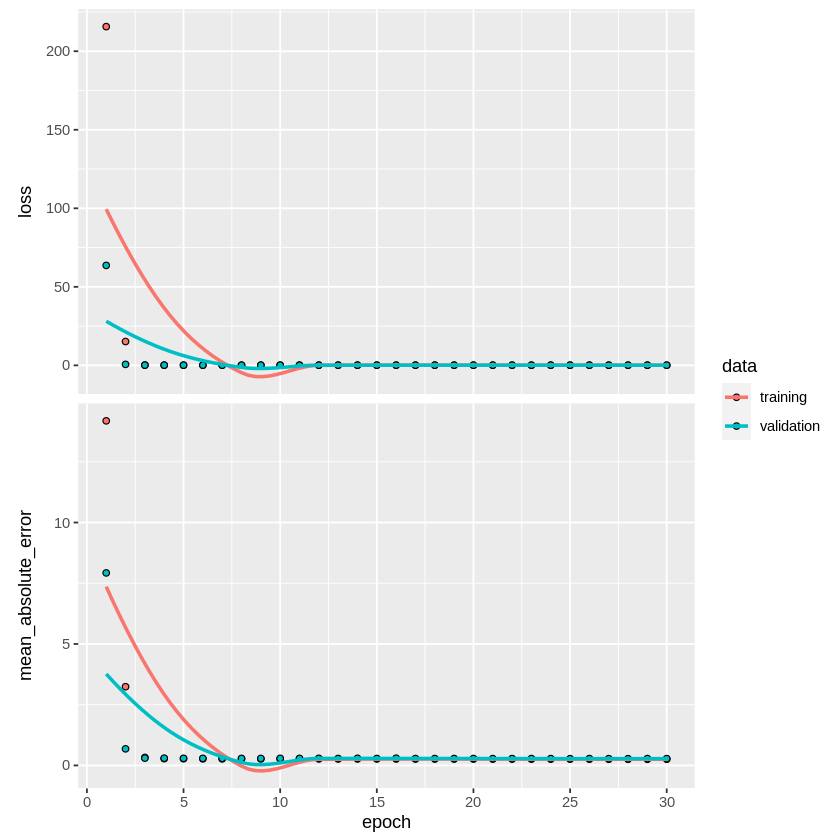

In [ ]:
plot(history)

Evaluamos dentro de muestra

In [ ]:
y_hat_insample<- snn  %>% predict(x_train)

Mean Absolute Error dentro de muestra

In [ ]:
mean(abs(exp(y_hat_insample)-train$price))

[1] 175898121

Predecimos fuera de muestra

In [ ]:
test<-test %>% mutate(
  nbanios=as.numeric(nbanios),
  nhabitaciones=as.numeric(nhabitaciones),
  piso_apartamento=as.numeric(piso_apartamento),
  estrato=as.numeric(estrato),
  Periodo=as.numeric(Periodo),
  Robos_vivienda=as.numeric(Robos_vivienda),
  Robos_personas=as.numeric(Robos_personas),
  distancia_estacion_policia=as.numeric(distancia_estacion_policia)
  )

test <- test %>%
  mutate(distancia_hospital = str_replace_all(distancia_hospital, "\\.", ""),
         distancia_hospital = str_replace_all(distancia_hospital, ",", "."),
         distancia_hospital = as.numeric(distancia_hospital))

x_test<- as.matrix(test  %>% select(predictores_net_1))
x_test<- scale(x_test)
head(x_test)

,nbanios,nhabitaciones,piso_apartamento,estrato,Periodo,Robos_vivienda,Robos_personas,distancia_estacion_policia,distancia_hospital
1,0.6031259,0.6319575,0.3396711,0.5963502,-0.03416316,-0.225038,-0.09600284,0.03783256,-1.731688
2,-1.4114068,-0.4112643,0.3396711,0.5963502,-0.03416316,-0.225038,-0.09600284,-0.56795257,-1.731416
3,0.6031259,0.6319575,-0.8262434,0.5963502,-0.03416316,-0.225038,-0.09600284,-1.19609322,-1.731119
4,-0.4041404,-1.4544861,-0.4376052,-2.2785403,-0.03416316,-0.225038,-0.09600284,-0.75787662,-1.730710
5,-0.4041404,-1.4544861,-0.4376052,-2.2785403,-0.03416316,-0.225038,-0.09600284,-0.74385847,-1.730368
6,-0.4041404,0.6319575,-0.8262434,-2.2785403,-0.03416316,-0.225038,-0.09600284,-0.80201565,-1.730192


In [ ]:
y_hat_outsample <- snn  %>% predict(x_test)

In [ ]:
summary(exp(y_hat_outsample))

       V1           
 Min.   :1.469e+07  
 1st Qu.:4.563e+08  
 Median :6.501e+08  
 Mean   :7.113e+08  
 3rd Qu.:9.933e+08  
 Max.   :1.427e+09  

Exportamos las predicciones

In [ ]:
sub_net_1<-test %>% select(property_id)
sub_net_1<-cbind(property_id=sub_net_1,
                 price=exp(y_hat_outsample))
head(sub_net_1)
summary(sub_net_1$price)
table(is.na(sub_net_1$price))


,property_id,price
,<chr>,<dbl>
1,d56159653f5d2abc5ed5acd7,996012839
2,735deef3382aa15930482f3e,532471784
3,7d3220a91e78f8bc2924d1cd,1047973814
4,d3054072b2175deec2c1f8dc,470795542
5,b7574b06d593fca4eac59815,470793746
6,79e822115c5c1a4531366001,501802969


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
1.469e+07 4.563e+08 6.501e+08 7.113e+08 9.933e+08 1.427e+09 


FALSE 
10286 

In [ ]:
write.csv(x = sub_net_1,"Submit_net_1.csv",row.names=FALSE)


Con una función de activación ReLu

In [ ]:
snn2 <- keras_model_sequential() %>%
  layer_dense(units = 25, activation = "relu",
              input_shape = ncol(x_train)) %>%
  layer_dense(units = 1)

snn2 %>% compile(loss = "mse",
                  optimizer = 'adam',
                  metrics = list("mean_absolute_error") # mean_absolute_error
)


set.seed(10101)
history <- snn %>% fit(
  x_train, y_train,
  epochs = 30,
  validation_split = 0.3
)


In [ ]:
y_hat_insample2<- snn2  %>% predict(x_train)

mean(abs(exp(y_hat_insample2)-train$price))

[1] 654534674

El MAE aumenta dentro de muestra. Se prefiere añadir más capas a la red

In [ ]:
snn2 <- keras_model_sequential() %>%
  layer_dense(units = 25, activation = "sigmoid",
              input_shape = ncol(x_train)) %>%
  layer_dense(units = 15, activation = "sigmoid",
              input_shape = ncol(x_train)) %>%
  layer_dense(units = 5, activation = "sigmoid",
              input_shape = ncol(x_train)) %>%
  layer_dense(units = 1)

snn2 %>% compile(loss = "mse",
                  optimizer = 'adam',
                  metrics = list("mean_absolute_error") # mean_absolute_error
)


set.seed(10101)
history <- snn %>% fit(
  x_train, y_train,
  epochs = 30,
  validation_split = 0.3
)


In [ ]:
y_hat_insample2<- snn2  %>% predict(x_train)

mean(abs(exp(y_hat_insample2)-train$price))

[1] 654534675

Probamos una combiación de funciones de activación

In [ ]:
snn2 <- keras_model_sequential() %>%
  layer_dense(units = 25, activation = "sigmoid",
              input_shape = ncol(x_train)) %>%
  layer_dense(units = 15, activation = "sigmoid",
              input_shape = ncol(x_train)) %>%
  layer_dense(units = 5, activation = "relu",
              input_shape = ncol(x_train)) %>%
  layer_dense(units = 1)

snn2 %>% compile(loss = "mse",
                  optimizer = 'adam',
                  metrics = list("mean_absolute_error") # mean_absolute_error
)


set.seed(10101)
history <- snn %>% fit(
  x_train, y_train,
  epochs = 30,
  validation_split = 0.3
)


In [ ]:
y_hat_insample2<- snn2  %>% predict(x_train)

mean(abs(exp(y_hat_insample2)-train$price))

[1] 654534674

Dado que no parece haber un cambio de los resultados con el cambio de hiperparámetros se decide probar fuera de muestra.

In [ ]:
y_hat_outsample_2 <- snn  %>% predict(x_test)

sub_net_2<-test %>% select(property_id)
sub_net_2<-cbind(property_id=sub_net_2,
                 price=exp(y_hat_outsample_2))
head(sub_net_2)
summary(sub_net_2$price)
table(is.na(sub_net_2$price))

,property_id,price
,<chr>,<dbl>
1,d56159653f5d2abc5ed5acd7,935885224
2,735deef3382aa15930482f3e,600303512
3,7d3220a91e78f8bc2924d1cd,1009964481
4,d3054072b2175deec2c1f8dc,538635371
5,b7574b06d593fca4eac59815,538312875
6,79e822115c5c1a4531366001,480723474


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
2.032e+06 4.555e+08 6.427e+08 7.195e+08 9.735e+08 1.636e+09 


FALSE 
10286 

In [ ]:
write.csv(x = sub_net_2,"Submit_net_2.csv",row.names=FALSE)